In [1]:
from qutip import *
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from quantum_logical.channel import AmplitudeDamping, PhaseDamping
from quantum_logical.trotter import TrotterGroup
from tqdm import tqdm
from quantum_logical.operators import selective_destroy
from scipy.optimize import curve_fit

<p align="center"><img src = "https://i.sstatic.net/mbg8X.jpg">

In [2]:
# generating parameters and creating initial state
T1 = 40000
T2 = 20000
N = 5
dim = 2
trotter_dt = .02
psi0 = qt.tensor((qt.basis(dim, 1)).unit(), qt.basis(dim, 0), qt.basis(dim, 0), qt.basis(dim, 0), qt.basis(dim, 0))
# psi0 = qt.basis(dim, 1)
rho0 = psi0 * psi0.dag()
amp_damp_channel = AmplitudeDamping(T1, num_qubits=N, hilbert_space_dim=dim)
phase_damp_channel = PhaseDamping(T1, T2, num_qubits=N, hilbert_space_dim=dim)
trotter = TrotterGroup(
    continuous_operators=[amp_damp_channel, phase_damp_channel],
    trotter_dt=trotter_dt,
)


# qt.Qobj(amp_damp_channel._create_single_qubit_operators(T1=1)[1])
# identity = qt.qeye(dim ** N)

In [3]:
# creating the set of cnots
cnot1 = qt.cnot(N=5, control=0, target=1)
cnot2 = qt.cnot(N=5, control=0, target=2)

cnot3 = qt.cnot(N=5, control=0, target=3)
cnot4 = qt.cnot(N=5, control=1, target=3)

cnot5 = qt.cnot(N=5, control=1, target=4)
cnot6 = qt.cnot(N=5, control=2, target=4)

x_gate = qt.Qobj([[0, 1],[1, 0]])


/var/folders/nc/8sqqbv456mdfx096ks86vy8m0000gn/T/ipykernel_31944/2987813776.py:2: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  cnot1 = qt.cnot(N=5, control=0, target=1)
/var/folders/nc/8sqqbv456mdfx096ks86vy8m0000gn/T/ipykernel_31944/2987813776.py:3: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  cnot2 = qt.cnot(N=5, control=0, target=2)
/var/folders/nc/8sqqbv456mdfx096ks86vy8m0000gn/T/ipykernel_31944/2987813776.py:5: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instea

In [4]:
# creating the initial state and encoding it 
psi0 = qt.tensor(qt.basis(dim, 1), qt.basis(dim, 0), qt.basis(dim, 0), qt.basis(dim, 0), qt.basis(dim, 0))
rho0 = psi0 * psi0.dag()
rho_encoded = cnot2 * cnot1 * rho0 * cnot1.dag() * cnot2.dag()
# trace out the ancillas to get the true result
rho_encoded_traced = qt.ptrace(rho_encoded, [0, 1, 2])
# the correct initial state has been prepared 
rho_encoded_traced 

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]

In [5]:
# store the states and the fidelities that come out
states = []
fids = []

In [6]:
# run the circuit 
initial_time = 10
initial_state_relax = trotter.apply(rho_encoded, duration=initial_time, discrete_unitary=qt.qeye(dim ** N))
states.extend(initial_state_relax)
fids.append(qt.fidelity(qt.ptrace(initial_state_relax[-1], [0, 1, 2]), rho_encoded_traced))

# now apply the cnots to the circuit 
cnot_gate_overall = cnot6 * cnot5 * cnot4 * cnot3

syndrome_time = 40
after_syndrome_extraction = trotter.apply(initial_state_relax[-1], duration= syndrome_time, discrete_unitary=cnot_gate_overall)
states.extend(after_syndrome_extraction)
fids.append(qt.fidelity(qt.ptrace(after_syndrome_extraction[-1], [0, 1, 2]), rho_encoded_traced))


In [7]:
r00 = qt.tensor(qt.qeye(dim ** N))
r01 = qt.Qobj((qt.tensor(qt.qeye(dim), x_gate, qt.qeye(dim ** 3))).full())
r10 = qt.Qobj((qt.tensor(x_gate, qt.qeye(dim ** 4))).full())
r11 = qt.Qobj((qt.tensor(qt.qeye(dim), qt.qeye(dim), x_gate, qt.qeye(dim ** 2))).full())

In [8]:
# recovery algorithm
correction_op = (r00 * qt.Qobj(qt.tensor(qt.qeye(dim), qt.qeye(dim), qt.qeye(dim), (qt.tensor(qt.basis(dim, 0), qt.basis(dim, 0)) * (qt.tensor(qt.basis(dim, 0), qt.basis(dim, 0))).dag())).full()) +
                 r01 * qt.Qobj(qt.tensor(qt.qeye(dim), qt.qeye(dim), qt.qeye(dim), (qt.tensor(qt.basis(dim, 0), qt.basis(dim, 1)) * (qt.tensor(qt.basis(dim, 0), qt.basis(dim, 1))).dag())).full()) +
                 r10 * qt.Qobj(qt.tensor(qt.qeye(dim), qt.qeye(dim), qt.qeye(dim), (qt.tensor(qt.basis(dim, 1), qt.basis(dim, 0)) * (qt.tensor(qt.basis(dim, 1), qt.basis(dim, 0))).dag())).full()) +
                 r11 * qt.Qobj(qt.tensor(qt.qeye(dim), qt.qeye(dim), qt.qeye(dim), (qt.tensor(qt.basis(dim, 1), qt.basis(dim, 1)) * (qt.tensor(qt.basis(dim, 1), qt.basis(dim, 1))).dag())).full())
)

measurement_dur = .02
# measurement = trotter.apply(final_state, duration=measurement_dur, discrete_unitary=qt.qeye(dim ** N))
measurement = trotter.apply(after_syndrome_extraction[-1], duration=measurement_dur, discrete_unitary=correction_op)
states.extend(measurement)
fids.append(qt.fidelity(qt.ptrace(measurement[-1], [0, 1, 2]), rho_encoded_traced))

In [9]:
# final relaxation cycle
relaxation_time = 10
relaxation = trotter.apply(measurement[-1], duration=relaxation_time, discrete_unitary=qt.qeye(dim ** N))
states.extend(relaxation)
fids.append(qt.fidelity(qt.ptrace(relaxation[-1], [0, 1, 2]), rho_encoded_traced))

In [10]:
total_cirquit_duration = initial_time + syndrome_time + relaxation_time + measurement_dur
time_list = np.linspace(0, total_cirquit_duration, len(states))

In [11]:
# trace out the ancillas
state_sim = []
for i in range(len(states)):
    state_sim.append(qt.ptrace(states[i], [0, 1, 2]))


In [12]:
state_sim[0]

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 9.9999975e-08 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  9.9999975e-08 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 9.9999975e-08 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.000

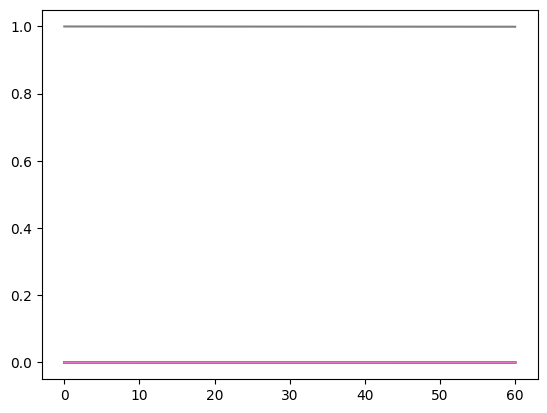

In [13]:
# plot
fig, ax = plt.subplots()
for i in range(dim ** 3):
    datas = []
    for j in range(len(states)):
        # print(np.real(states[j][i, i]))
        datas.append(np.real(state_sim[j][i, i]))  
    ax.plot(time_list, datas)
# datas = []
# for i in range(len(states)- 12000):
#     print(np.real(states[i][0, 0])) 
#     datas.append(np.real(states[i][0, 0]))

# ax.plot(time_list[0:38032], datas)

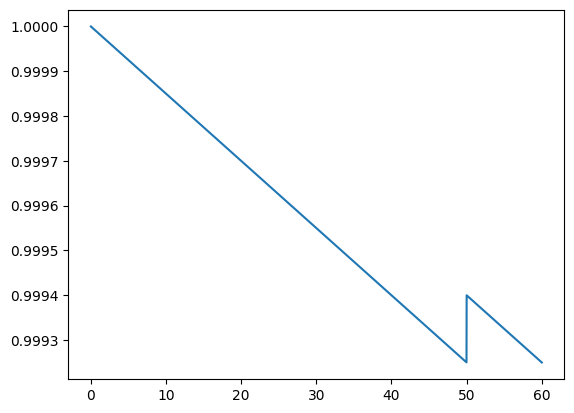

In [14]:
# label these plots with the states
fig, ax = plt.subplots()
datas = []
for j in range(len(state_sim)):
    # print(np.real(states[j][i, i]))
    datas.append(np.real(state_sim[j][7, 7]))    
ax.plot(time_list, datas)

In [15]:
fids

[0.999925002819937, 0.9996250703412993, 0.9996999276597099, 0.9996249529842262]

## The top of this confirms the qubit bit flip code <br />
## give different setups and report that 

In [16]:
def stabilizer(initial_state, rho_encoded_original, time_list):
    fid_list = []
    state_list = []
    

    # initialization and syndrome detection
    initial_time = time_list[0]
    initial_state_relax = trotter.apply(initial_state, duration=initial_time, discrete_unitary=qt.qeye(dim ** N))
    state_list.extend(initial_state_relax)
    fid_list.append(qt.fidelity(qt.ptrace(initial_state_relax[-1], [0, 1, 2]), rho_encoded_original))

    # now apply the cnots to the circuit 
    cnot_gate_overall = cnot6 * cnot5 * cnot4 * cnot3

    syndrome_time = time_list[1]
    after_syndrome_extraction = trotter.apply(initial_state_relax[-1], duration= syndrome_time, discrete_unitary=cnot_gate_overall)
    state_list.extend(after_syndrome_extraction)
    fid_list.append(qt.fidelity(qt.ptrace(after_syndrome_extraction[-1], [0, 1, 2]), rho_encoded_original))

    # measurement and correction
    # recovery gates 
    r00 = qt.tensor(qt.qeye(dim ** N))
    r01 = qt.Qobj((qt.tensor(qt.qeye(dim), x_gate, qt.qeye(dim ** 3))).full())
    r10 = qt.Qobj((qt.tensor(x_gate, qt.qeye(dim ** 4))).full())
    r11 = qt.Qobj((qt.tensor(qt.qeye(dim), qt.qeye(dim), x_gate, qt.qeye(dim ** 2))).full())

    
    # recovery algorithm
    correction_op = (r00 * qt.Qobj(qt.tensor(qt.qeye(dim), qt.qeye(dim), qt.qeye(dim), (qt.tensor(qt.basis(dim, 0), qt.basis(dim, 0)) * (qt.tensor(qt.basis(dim, 0), qt.basis(dim, 0))).dag())).full()) +
                    r01 * qt.Qobj(qt.tensor(qt.qeye(dim), qt.qeye(dim), qt.qeye(dim), (qt.tensor(qt.basis(dim, 0), qt.basis(dim, 1)) * (qt.tensor(qt.basis(dim, 0), qt.basis(dim, 1))).dag())).full()) +
                    r10 * qt.Qobj(qt.tensor(qt.qeye(dim), qt.qeye(dim), qt.qeye(dim), (qt.tensor(qt.basis(dim, 1), qt.basis(dim, 0)) * (qt.tensor(qt.basis(dim, 1), qt.basis(dim, 0))).dag())).full()) +
                    r11 * qt.Qobj(qt.tensor(qt.qeye(dim), qt.qeye(dim), qt.qeye(dim), (qt.tensor(qt.basis(dim, 1), qt.basis(dim, 1)) * (qt.tensor(qt.basis(dim, 1), qt.basis(dim, 1))).dag())).full())
    )

    measurement_dur = time_list[2]
    # measurement = trotter.apply(final_state, duration=measurement_dur, discrete_unitary=qt.qeye(dim ** N))
    measurement = trotter.apply(after_syndrome_extraction[-1], duration=measurement_dur, discrete_unitary=correction_op)
    state_list.extend(measurement)
    fid_list.append(qt.fidelity(qt.ptrace(measurement[-1], [0, 1, 2]), rho_encoded_original))

    # final relaxation of cycle 
    relaxation_time = time_list[3]
    relaxation = trotter.apply(measurement[-1], duration=relaxation_time, discrete_unitary=qt.qeye(dim ** N))
    state_list.extend(relaxation)
    fid_list.append(qt.fidelity(qt.ptrace(relaxation[-1], [0, 1, 2]), rho_encoded_original))

    return state_list, fid_list

    

In [17]:
time_list = [5, 40, .02, 5] # [initialize relaxation, syndrome detection, measurement and recovery, final relaxation]

result_states = []
result_fids = []

# doing stabilizers for multiple iterations
iterations = 300
iter_list = [] # for graphing purposes 

# building the data
for i in range(iterations):
    iter_list.append(i)
    a, b = stabilizer(initial_state=rho_encoded, rho_encoded_original=rho_encoded_traced, time_list=time_list)
    result_states.extend(a)
    result_fids.extend(b)
    rho_encoded = result_states[-1]


In [18]:
# create the list of time for the amount of iterations
total_time = iterations * sum(time_list)

time_plot = np.linspace(0, total_time, len(result_states))

In [19]:
# analyze the data
plotted_fids = []
for i in range(int(len(result_fids) / 4)):
    plotted_fids.append(result_fids[i * 4 + 3])    


In [20]:
# trace out the ancillas
state_sim = []
for i in range(len(result_states)):
    state_sim.append(qt.ptrace(result_states[i], [0, 1, 2]))

75773.5566924038


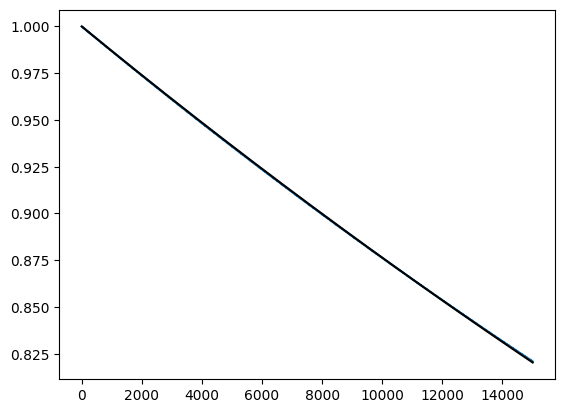

In [21]:
# plotting the data 

# state vs time 
fig, ax = plt.subplots()
datas = []
for j in range(len(state_sim)):
    datas.append(np.real(state_sim[j][7, 7]))    
ax.plot(time_plot, datas)

# fitting the data
def function_fit(t, b):
    return np.exp(-t / b)

parameters, covariance = curve_fit(function_fit, time_plot, datas)

fit_func = function_fit(time_plot, parameters[0])
ax.plot(time_plot, fit_func, color = "black", linestyle = "-", label = "fitted line")
# plt.plot(time_idle, datas, color = "orange", marker = ".", alpha = 0.01)


T1_stabilizer = parameters[0]
print(parameters[0]) 

# fit the data


In [22]:
# creating the initial state and encoding it 
psi0 = qt.tensor(qt.basis(dim, 1), qt.basis(dim, 0), qt.basis(dim, 0), qt.basis(dim, 0), qt.basis(dim, 0))
rho0 = psi0 * psi0.dag()
rho_encoded = cnot2 * cnot1 * rho0 * cnot1.dag() * cnot2.dag()

comparing to idle decay

In [23]:
ana_states = []
ana_fids = []
analysis_t1 = trotter.apply(rho_encoded, duration = 350, discrete_unitary=qt.qeye(dim ** N))
ana_states.extend(analysis_t1)
ana_fids.append(qt.fidelity(qt.ptrace(analysis_t1[-1], [0, 1, 2]), rho_encoded_traced))

time_idle = np.linspace(0, 350, len(ana_states))

# trace out the ancillas and then plot 
new_states_sim = []
for i in range(len(ana_states)):
    new_states_sim.append(qt.ptrace(ana_states[i], [0, 1, 2]))

66664.7637882379


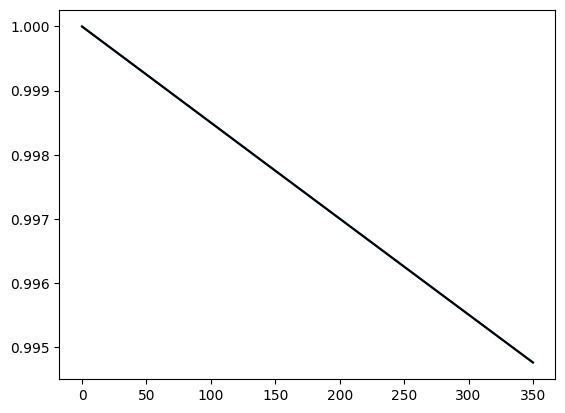

In [24]:
# plot this new idle circuit 
fig, ax = plt.subplots()
datas = []
for j in range(len(new_states_sim)):
    datas.append(np.real(new_states_sim[j][7, 7]))    
ax.plot(time_idle, datas)


# fitting the data

parameters, covariance = curve_fit(function_fit, time_idle, datas)

fit_func = function_fit(time_idle, parameters[0])
ax.plot(time_idle, fit_func, color = "black", linestyle = "-", label = "fitted line")
# plt.plot(time_idle, datas, color = "orange", marker = ".", alpha = 0.01)


T1_idle = parameters[0]
print(parameters[0]) 

back to the stabilizer form

In [25]:
Beta = T1_stabilizer / T1_idle
Beta

1.1366357935820515

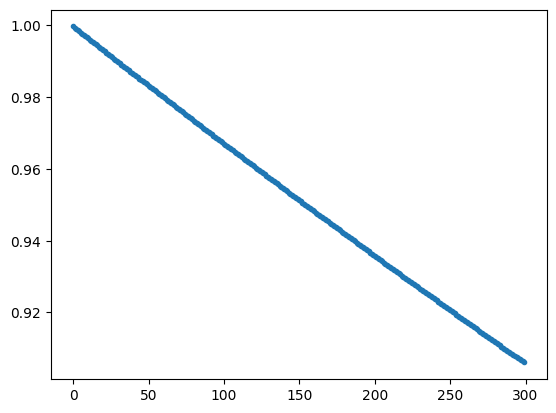

In [26]:
# fidelity vs iteraction (the final fidelity only)
fig, ax = plt.subplots()
ax.plot(iter_list, plotted_fids, marker = ".")